In [41]:
import wandb
import torch
import torch.nn as nn
import pandas as pd
import seaborn as sns
import lovely_tensors
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
import math
import matplotlib.pyplot as plt
import seaborn as sns

lovely_tensors.monkey_patch()

In [106]:
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, out_dim, dim=50, max_len=1000):
        super().__init__()

        self.pos_enc = nn.Parameter(torch.zeros(max_len, dim))
        self._init_pos_enc(dim, max_len)

        self.linear1 = nn.Linear(dim, out_dim)
        self.linear2 = nn.Linear(out_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, t):
        x = self.pos_enc[t]
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

    def _init_pos_enc(self, d_model, max_len):
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        self.pos_enc.data[:, 0::2] = torch.sin(position * div_term)
        self.pos_enc.data[:, 1::2] = torch.cos(position * div_term)

In [105]:
class BackwardsDiffusionModel(nn.Module):
    def __init__(self, in_dim=2, dim=128, num_steps=1000):
        super().__init__()

        self.pos_enc = LearnablePositionalEncoding(dim)

        self.linear1 = nn.Linear(in_dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.linear3 = nn.Linear(dim, dim)
        self.linear4 = nn.Linear(dim, in_dim)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor, t: int):
        pos_enc = self.pos_enc(t)

        x = self.relu(self.linear1(x) + pos_enc)
        x = self.relu(self.linear2(x) + pos_enc)
        x = self.relu(self.linear3(x) + pos_enc)
        x = self.linear4(x)

        return x

In [44]:
x = torch.randn(128, 16)
t = torch.ones(128, dtype=torch.long) 

model = BackwardsDiffusionModel(in_dim=16) 
model(x, t)

tensor[128, 16] n=2048 (8Kb) x∈[-0.270, 0.282] μ=0.019 σ=0.090 grad AddmmBackward0

---

In [84]:
class DDPM:
    def __init__(
        self, backward_model, num_steps=1000, beta_start=0.0001, beta_end=0.02, use_sigmoid=False, device="cpu"
    ):
        self.device = torch.device(device)
        self.num_steps = num_steps
        self.backward_model = backward_model.to(device)

        if use_sigmoid:
            self.alpha_cumprod = sigmoid(torch.linspace(5, -5, num_steps))
            alphas = torch.zeros_like(self.alpha_cumprod)
            alphas[0] = 1 - beta_start
            alphas[1:] = self.alpha_cumprod[1:] / self.alpha_cumprod[:-1]
            self.alphas = alphas
            self.betas = 1 - alphas
        else:
            self.betas = torch.linspace(beta_start, beta_end, num_steps)
            self.alphas = 1 - self.betas
            self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

        self.alpha_cumprod = self.alpha_cumprod.to(device)
        self.alphas = self.alphas.to(device)
        self.betas = self.betas.to(device)

    @torch.no_grad()
    def forward_diffusion(self, x, t, noise=None):
        if type(t) == int:
            t = torch.tensor([t])
        noise = torch.randn_like(x) if noise is None else noise

        a = torch.sqrt(self.alpha_cumprod[t]).unsqueeze(1)
        b = torch.sqrt(1 - self.alpha_cumprod[t]).unsqueeze(1)

        return a * x + b * noise

    @torch.no_grad()
    def generate(self, n):
        x = torch.randn((n, 2), device=self.device)

        for t in range(self.num_steps - 1, -1, -1):
            z = torch.randn_like(x) if t >= 1 else torch.zeros_like(x)
            t_tensor = torch.full((n,), t, device=self.device, dtype=torch.long)
            noise_pred = self.backward_model(x, t_tensor)

            a_t = self.alphas[t]
            a_bar_t = self.alpha_cumprod[t]

            x = (1 / a_t.sqrt()) * (x - noise_pred * (1 - a_t) / (1 - a_bar_t).sqrt()) + (1 - a_t).sqrt() * z

        return x

In [63]:
def plot(X, limit=2000, show=True):
    fig, ax = plt.subplots()
    sns.scatterplot(x=X[:, 0], y=X[:, 1], ax=ax, s=1)

    plt.show()

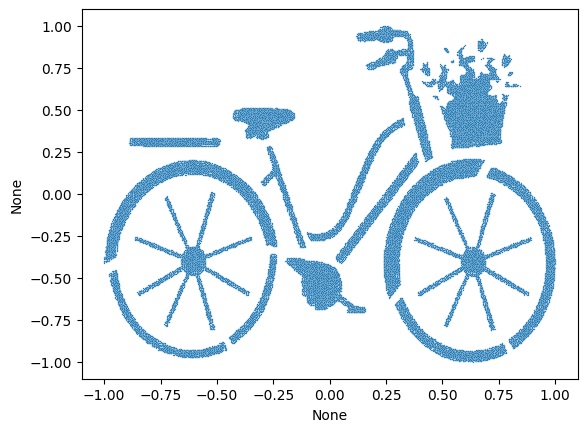

tensor[50468, 2] n=100936 (0.4Mb) x∈[-1.000, 1.000] μ=0.026 σ=0.531

In [60]:
df = pd.read_csv("bicycle.txt", header=None, delimiter=" ")
df = df.sample(frac=1)
X = torch.tensor(df.values).float()
plot(X)
X

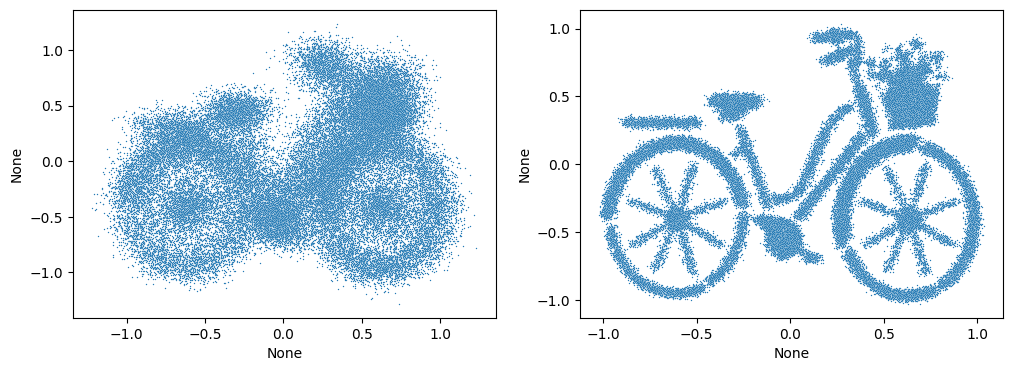

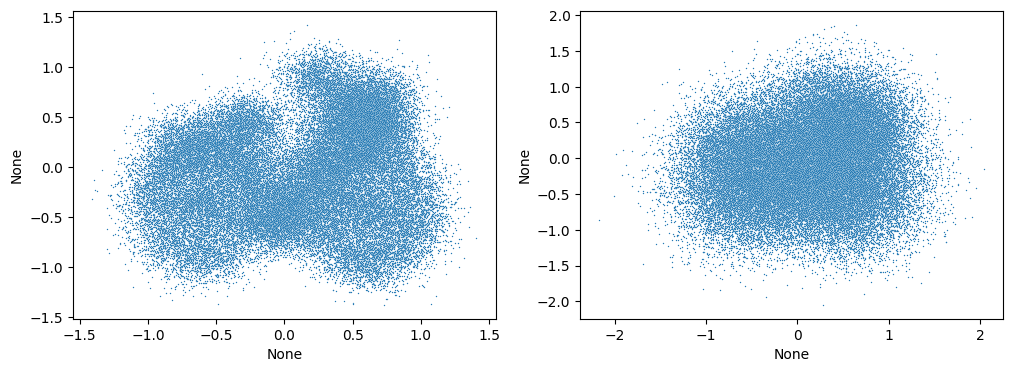

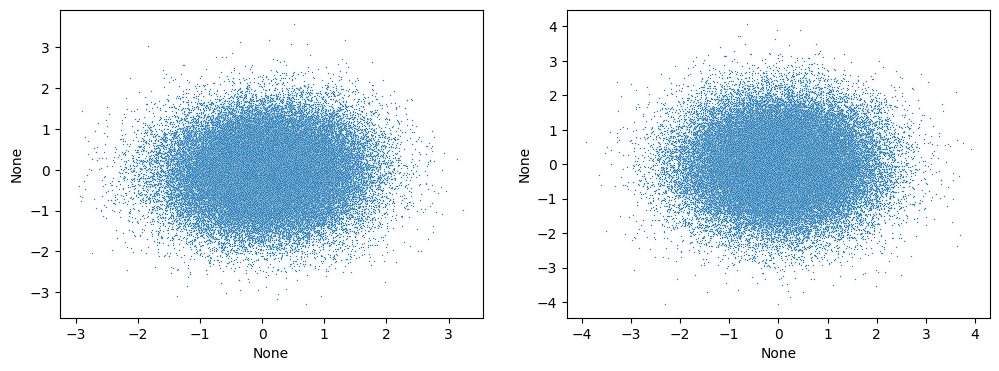

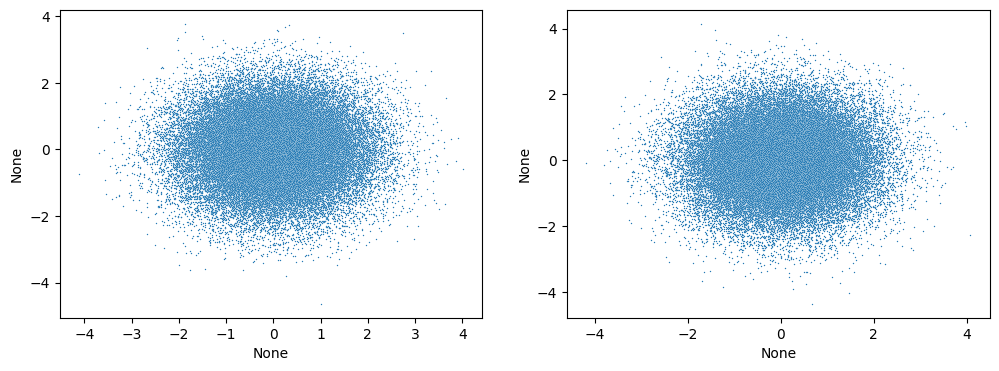

In [92]:
ddpm = DDPM(BackwardsDiffusionModel(in_dim=2), use_sigmoid=True)
ddpm2 = DDPM(BackwardsDiffusionModel(in_dim=2), use_sigmoid=False)

for t in [1, 100, 500, 999]:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    diff_X = ddpm.forward_diffusion(X, t)
    diff_X_2 = ddpm2.forward_diffusion(X, t)
    
    sns.scatterplot(x=diff_X[:, 0], y=diff_X[:, 1], ax=axs[0], s=1)
    sns.scatterplot(x=diff_X_2[:, 0], y=diff_X_2[:, 1], ax=axs[1], s=1)
    plt.show()

In [98]:
import math
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=1000):
        super().__init__()
        self.register_buffer("pos_enc", self._init_pos_enc(dim, max_len))

    def _init_pos_enc(self, d_model, max_len):
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pos_enc = torch.zeros(max_len, d_model)
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)

        return pos_enc

    def forward(self, t):
        t = torch.clamp(t, max=999) 
        return self.pos_enc[t]

class BackwardsDiffusionModel(nn.Module):
    def __init__(self, in_dim=2, dim=128, num_steps=1000):
        super().__init__()

        self.pos_enc = PositionalEncoding(dim)

        self.linear1 = nn.Linear(in_dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.linear3 = nn.Linear(dim, dim)
        self.linear4 = nn.Linear(dim, in_dim)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor, t: int):
        pos_enc = self.pos_enc(t)

        x = self.relu(self.linear1(x) + pos_enc)
        x = self.relu(self.linear2(x) + pos_enc)
        x = self.relu(self.linear3(x) + pos_enc)
        x = self.linear4(x)

        return x

In [99]:
# Inicjalizacja modelu
model = BackwardsDiffusionModel(in_dim=2, dim=128, num_steps=1000)

# Dane wejściowe
x = torch.randn(4, 2)  # batch_size=4, in_dim=2
t = torch.tensor(42)   # krok czasowy t

# Wywołanie modelu
output = model(x, t)

# Sprawdzenie wymiarów wejścia i wyjścia
print("Wymiary wejścia:", x.shape)    # Oczekiwane: (4, 2)
print("Wymiary wyjścia:", output.shape)  # Oczekiwane: (4, 2)

Wymiary wejścia: torch.Size([4, 2])
Wymiary wyjścia: torch.Size([4, 2])


<Axes: >

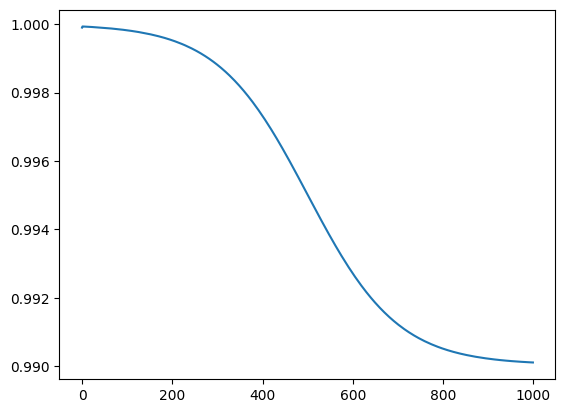

In [81]:
sns.lineplot(ddpm.alphas.cpu())

<Axes: >

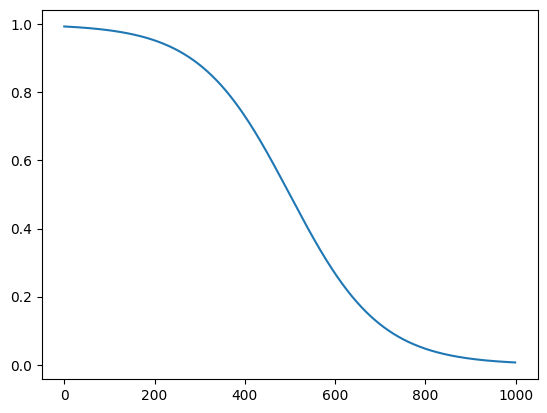

In [83]:
sns.lineplot(ddpm.alpha_cumprod.cpu())

In [51]:
df = pd.read_csv("bicycle.txt", header=None, delimiter=" ")
df = df.sample(frac=1)
X = torch.tensor(df.values).float()

train_loader = DataLoader(X, batch_size=128, shuffle=True)
test_loader = DataLoader(X, batch_size=128, shuffle=True)

In [101]:
# Zapis punktów kontrolnych
def save_checkpoint(model, optimizer, epoch, loss, path):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": loss,
    }, path)


In [125]:
import numpy as np
import matplotlib.pyplot as plt

def plot(image_data, show=True):
    """
    Function to plot the generated image data using seaborn's scatterplot.
    The image data will be clipped to the range [-4, 4] for both axes.
    """
    # Assuming image_data is a 2D tensor or numpy array with shape (n_samples, n_features)
    image_data = image_data.numpy()  # Convert tensor to numpy if needed
    
    # Ensure the data is in the range [-4, 4]
    image_data = np.clip(image_data, -4, 4)
    
    # Create a figure and axis for plotting
    fig, axs = plt.subplots(figsize=(6, 6))
    
    # Plot using seaborn's scatterplot
    sns.scatterplot(x=image_data[:, 0], y=image_data[:, 1], ax=axs, s=1)
    axs.set_xlim(-4, 4)
    axs.set_ylim(-4, 4)
    
    if show:
        plt.show()

In [ ]:
import os
import json
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

# Klasa do logowania lokalnego (zapis metryk i obrazów)
class LocalLogger:
    def __init__(self, log_dir="logs"):
        self.log_dir = log_dir
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.run_dir = os.path.join(log_dir, f"run_{self.timestamp}")
        self.metrics_file = os.path.join(self.run_dir, "metrics.json")
        self.images_dir = os.path.join(self.run_dir, "images")
        
        # Tworzenie katalogów
        os.makedirs(self.run_dir, exist_ok=True)
        os.makedirs(self.images_dir, exist_ok=True)
        
        self.metrics = []
    
    def log(self, metrics_dict):
        metrics_dict["timestamp"] = datetime.now().isoformat()
        self.metrics.append(metrics_dict)
        with open(self.metrics_file, "w") as f:
            json.dump(self.metrics, f, indent=2)

# Przygotowanie modelu, optymalizatora i straty
backward_model = BackwardsDiffusionModel(in_dim=2, dim=128, num_steps=1000)
optimizer = Adam(backward_model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Inicjalizacja loggera
logger = LocalLogger()

# Symulowany loader danych
def synthetic_data_loader(batch_size, num_batches):
    for _ in range(num_batches):
        yield torch.randn(batch_size, 2)  # batch_size x in_dim

train_loader = list(synthetic_data_loader(batch_size=4000, num_batches=100))  # Convert to list
total_epochs = 500
num_batches = len(train_loader)  # Liczba batchów na epokę
pbar = tqdm(total=total_epochs)

for epoch in range(total_epochs):
    running_loss = 0.0
    for x_0 in train_loader:  # Iterujemy po predefiniowanych batchach
        t = torch.randint(0, 1000, (x_0.size(0),))  # Losowy krok czasowy
        noise = torch.randn_like(x_0)  # Szum
        x_t = x_0 + noise  # Przybliżenie rozproszonego x_t
        noise_est = backward_model(x_t, t)  # Szacowanie szumu przez model
        loss = loss_fn(noise_est, noise)  # Obliczenie straty
        
        # Optymalizacja
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    # Obliczenie średniej straty na epokę
    running_loss /= num_batches
    pbar.update(1)
    pbar.set_description(f"Loss: {running_loss:.4f}")

    # Logowanie metryk
    metrics = {
        "epoch": epoch,
        "loss": running_loss,
        "lr": optimizer.param_groups[0]["lr"]
    }
    logger.log(metrics)

    # if epoch % 10 == 0:
    #     gen_X = ddpm.generate(1000)
    #     # Przekształcanie wyników do zakresu [-4, 4]
    #     gen_X = torch.clamp(gen_X, -4, 4)
        
    #     # Save generated images and add to metrics
    #     plot(gen_X, show=False)  # Save plot without showing
    #     plot(gen_X)  # Show the plot
        
    # Redukcja LR po 80% epok
    if epoch == int(0.8 * total_epochs):
        for param_group in optimizer.param_groups:
            param_group["lr"] /= 10
        print("Learning rate reduced")

# Zapis modelu na końcu
checkpoint_path = os.path.join(logger.run_dir, "final_model.pt")
save_checkpoint(backward_model, optimizer, total_epochs, running_loss, checkpoint_path)


Loss: 0.4988:   2%|▏         | 63/4000 [01:31<1:35:37,  1.46s/it]